In [2]:
# скрываем ворнинги и дебаг-сообщения tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# constants
WINDOW_SIZE = 32
BASE_AMZ_PETSHOP_PATH = Path('/home/jupyter/datasphere/s3/storage/prepared/amazon_petshop/')
BASE_SURF_METRICS_PATH = Path('/home/jupyter/datasphere/s3/storage/prepared/surf/')

In [5]:
# подгатавливаем данные из amazon petshop dataset
all_latency = []
all_rps = []
for file in BASE_AMZ_PETSHOP_PATH.iterdir():
    df = pd.read_csv(file)
    
    for col in df.columns:
        # заполнение NaN первым последующим значением. Если такового нет, то ближайшим предыдущим
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
        
        if df[col].isna().all():
            df[col] = 0
    
    all_latency.append(df.filter(like=' | latency | '))
    all_rps.append(df.filter(like=' | requests | '))

# фиттим скейлеры
latency_scaler = StandardScaler()
latency_scaler.fit(pd.concat(all_latency).values.reshape(-1, 1))

rps_scaler = StandardScaler()
rps_scaler.fit(pd.concat(all_rps).values.reshape(-1, 1))

# нормализуем и бъем на окна
amz_petshop_data = []
for df_set, scaler in ((all_latency, latency_scaler), (all_rps, rps_scaler)):
    for df in df_set:
        for col in df.columns:
            normalized = scaler.transform(df[[col]].values)
            amz_petshop_data.append(np.array([np.array(normalized[i:i + WINDOW_SIZE]) for i in range(0, len(normalized) - WINDOW_SIZE, WINDOW_SIZE // 4)]))
amz_petshop_data = np.concatenate(amz_petshop_data)
amz_petshop_data.shape

(27846, 32, 1)

In [6]:
# подготавливаем данные из surf machine metrics
# здесь все метрики (*_usage, [0;100]) имеют одинаковую природу, поэтому скейлер один
all_dfs = []
for file in BASE_SURF_METRICS_PATH.iterdir():
    df = pd.read_csv(file)
    
    for col in df.columns:
        # заполнение NaN первым последующим значением. Если такового нет, то ближайшим предыдущим
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
        
        if df[col].isna().all():
            df[col] = 0
    all_dfs.append(df)
    
scaler = StandardScaler()
scaler.fit(pd.concat(all_dfs).values.reshape(-1, 1))

surf_data = []
for df in all_dfs:
    for col in df.columns:
        normalized = scaler.transform(df[[col]].values)
        surf_data.append(np.array([np.array(normalized[i:i + WINDOW_SIZE]) for i in range(0, len(normalized) - WINDOW_SIZE, WINDOW_SIZE // 4)]))
surf_data = np.concatenate(surf_data)
surf_data.shape

(6129324, 32, 1)

In [7]:
# подготавливаем синтетические данные
n_points = 1000

time = np.arange(n_points)

# синусоида
sin_wave = np.sin(np.pi * time / 16) + 4

# зашумленная синусоида
noisy_sin = sin_wave + np.random.normal(0, 0.15, n_points)

# линейный рост
linear = np.linspace(0, 10, n_points)

# прямая линия
constant = np.full(n_points, 5.0)

# белый шум
white_noise = np.random.normal(10, 1, n_points)

all_series = np.array([sin_wave, noisy_sin, linear, constant, white_noise])
scaler = StandardScaler()

all_series_2d = all_series.T.reshape(-1, 1)
scaler.fit(all_series_2d)

normalized_series = scaler.transform(all_series_2d).reshape(5, -1)

windows = []

step = WINDOW_SIZE // 4
for series in normalized_series:
    n_windows = (len(series) - WINDOW_SIZE) // step + 1
    
    for i in range(n_windows):
        start = i * step
        end = start + WINDOW_SIZE
        window = series[start:end]
        windows.append(window)

synt_data = np.array(windows)[..., np.newaxis]
synt_data.shape

(610, 32, 1)

In [ ]:
data = np.concatenate((amz_petshop_data, surf_data, synt_data))
X_train, X_test = train_test_split(data, test_size=0.3)
N_FEATURES = 1

inputs = Input(shape=(WINDOW_SIZE, N_FEATURES))
encoded = LSTM(64, return_sequences=True)(inputs)
encoded = LSTM(32, return_sequences=False)(encoded)

decoded = RepeatVector(WINDOW_SIZE)(encoded)
decoded = LSTM(32, return_sequences=True)(decoded)
decoded = LSTM(64, return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(N_FEATURES))(decoded)

model = Model(inputs, outputs)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    )
]

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_test, X_test),
    verbose=1,
    callbacks=callbacks,
)

model.save('lstm-ae-32-model-bs256.h5')

Epoch 1/50
16838/16838 [==============================] - 185s 11ms/step - loss: 0.5256 - val_loss: 0.4553 - lr: 0.0010
Epoch 2/50
16838/16838 [==============================] - 176s 10ms/step - loss: 0.3426 - val_loss: 0.2953 - lr: 0.0010
Epoch 3/50
16838/16838 [==============================] - 174s 10ms/step - loss: 0.2877 - val_loss: 0.3607 - lr: 0.0010
Epoch 4/50
16838/16838 [==============================] - 175s 10ms/step - loss: 0.2861 - val_loss: 0.3702 - lr: 0.0010
Epoch 5/50
16838/16838 [==============================] - 175s 10ms/step - loss: 0.9290 - val_loss: 0.2756 - lr: 0.0010
Epoch 6/50
16838/16838 [==============================] - 174s 10ms/step - loss: 0.2613 - val_loss: 0.3290 - lr: 0.0010
Epoch 7/50
16838/16838 [==============================] - 175s 10ms/step - loss: 0.2518 - val_loss: 0.2637 - lr: 0.0010
Epoch 8/50
16838/16838 [==============================] - 173s 10ms/step - loss: 0.2594 - val_loss: 0.2517 - lr: 0.0010
Epoch 9/50
16838/16838 [================

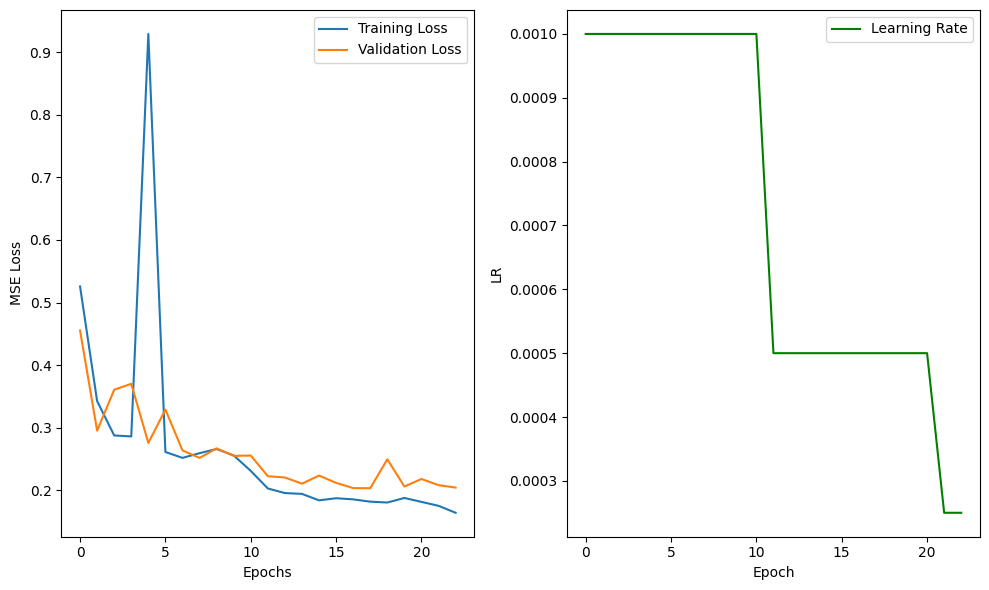

In [16]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lr'], label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend()

plt.tight_layout()
plt.show()

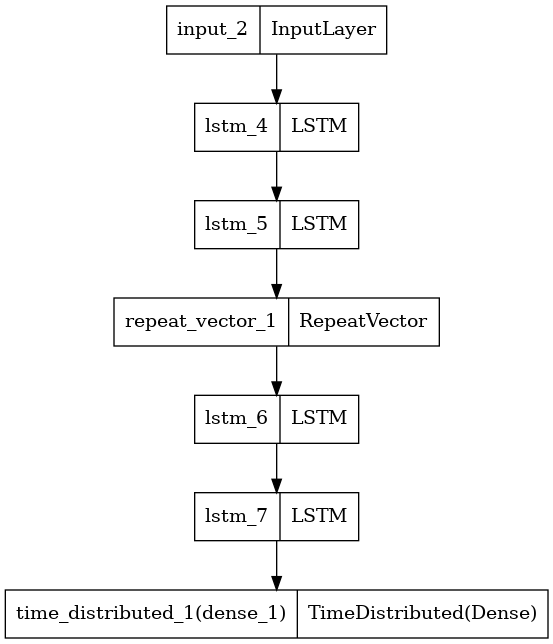

In [20]:
import keras
keras.utils.plot_model(model)